# Projeto 2 - Classificador Automático de Sentimento

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

## Informações do Projeto

Prazo: 13/Set até às 23:59.<br />
Grupo: 1 ou 2 pessoas.<br /><br />
Entregáveis via GitHub: 
* Arquivo notebook com o código do classificador, seguindo as orientações abaixo.
* Arquivo Excel com as bases de treinamento e teste totalmente classificado.

**NÃO disponibilizar o arquivo com os *access keys/tokens* do Twitter.**


### Check 3: 

Até o dia 06 de Setembro às 23:59, o notebook e o xlsx devem estar no Github com as seguintes evidências: 
    * Conta no twitter criada.
    * Produto escolhido.
    * Arquivo Excel contendo a base de treinamento e teste já classificado.

Sugestão de leitura:<br />
http://docs.tweepy.org/en/v3.5.0/index.html<br />
https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

___

## Preparando o ambiente

Instalando a biblioteca *tweepy* para realizar a conexão com o Twitter:

In [1]:
%%capture

#Instalando o tweepy
!pip install tweepy

Importando as Bibliotecas que serão utilizadas. Esteja livre para adicionar outras.

In [2]:
%matplotlib inline
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle

___
## Autenticando no  Twitter

Para realizar a captura dos dados é necessário ter uma conta cadastrada no twitter:

* Conta: ***[@LuccaDelchiaro]***


1. Caso ainda não tenha uma: https://twitter.com/signup
1. Depois é necessário registrar um app para usar a biblioteca: https://apps.twitter.com/
1. Dentro do registro do App, na aba Keys and Access Tokens, anotar os seguintes campos:
    1. Consumer Key (API Key)
    1. Consumer Secret (API Secret)
1. Mais abaixo, gere um Token e anote também:
    1. Access Token
    1. Access Token Secret
    
1. Preencha os valores no arquivo "auth.pass"

**ATENÇÃO**: Nunca divulgue os dados desse arquivo online (GitHub, etc). Ele contém as chaves necessárias para realizar as operações no twitter de forma automática e portanto é equivalente a ser "hackeado". De posse desses dados, pessoas mal intencionadas podem fazer todas as operações manuais (tweetar, seguir, bloquear/desbloquear, listar os seguidores, etc). Para efeito do projeto, esse arquivo não precisa ser entregue!!!

In [3]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

FileNotFoundError: [Errno 2] No such file or directory: 'auth.pass'

___
## Coletando Dados

Agora vamos coletar os dados. Tenha em mente que dependendo do produto escolhido, não haverá uma quantidade significativa de mensagens, ou ainda poder haver muitos retweets.<br /><br /> 
Configurando:

In [22]:
#Produto escolhido:
produto = 'Rick_and_Morty'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [23]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

NameError: name 'auth' is not defined

Salvando os dados em uma planilha Excel:

In [21]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

NameError: name 'produto' is not defined

___
## Classificando as Mensagens

Agora você deve abrir o arquivo Excel com as mensagens capturadas e classificar na Coluna B se a mensagem é relevante ou não.<br /> 
Não se esqueça de colocar um nome para a coluna na célula **B1**.<br /><br />
Fazer o mesmo na planilha de Controle.

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comece a desenvolver o classificador. Escreva o seu código abaixo:

Opcionalmente: 
* Limpar as mensagens removendo os caracteres: enter, :, ", ', (, ), etc. Não remover emojis.<br />
* Corrigir separação de espaços entre palavras e/ou emojis.
* Propor outras limpezas/transformações que não afetem a qualidade da informação.



In [147]:
#Importa excel e divide em dados relevantes e irrelevantes
data=pd.read_excel('Rick_and_Morty.xlsx')
data=data.iloc[:,[0,14]]
#filtra pontuação e palavras com pouca informação
data['Treinamento']=data['Treinamento'].str.replace(':','')
data['Treinamento']=data['Treinamento'].str.replace(',','')
data['Treinamento']=data['Treinamento'].str.replace("'",'')
data['Treinamento']=data['Treinamento'].str.replace('-','')
data['Treinamento']=data['Treinamento'].str.replace('"','')
data['Treinamento']=data['Treinamento'].str.replace(')','')
data['Treinamento']=data['Treinamento'].str.replace('(','')
data['Treinamento']=data['Treinamento'].str.replace(' é ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' a ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' o ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' e ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' os ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' as ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' ou ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' que ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' nas ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' na ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' no ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' nos ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' de ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' dos ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' das ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' da ',' ')
data['Treinamento']=data['Treinamento'].str.replace(' do ',' ')
data['Treinamento']=data['Treinamento'].str.replace('1','')
data['Treinamento']=data['Treinamento'].str.replace('2','')
data['Treinamento']=data['Treinamento'].str.replace('3','')
data['Treinamento']=data['Treinamento'].str.replace('4','')
data['Treinamento']=data['Treinamento'].str.replace('5','')
data['Treinamento']=data['Treinamento'].str.replace('6','')
data['Treinamento']=data['Treinamento'].str.replace('7','')
data['Treinamento']=data['Treinamento'].str.replace('8','')
data['Treinamento']=data['Treinamento'].str.replace('9','')
data['Treinamento']=data['Treinamento'].str.replace('0','')
data['Treinamento']=data['Treinamento'].str.replace('?','')
data['Treinamento']=data['Treinamento'].str.replace('!','')
data['Treinamento']=data['Treinamento'].str.replace('|','')
data['Treinamento']=data['Treinamento'].str.replace('/',' ')
data['Treinamento']=data['Treinamento'].str.replace('.',' ')


data['Treinamento']=data['Treinamento'].str.replace('  ',' ')

#separa em relevante  e irrelevante
rdata=data[(data.B1=="Relevante")].copy()
idata=data[(data.B1=="Irrelevante")].copy()

In [148]:
#Passa as palavras para listas
rdata['Treinamento']=rdata['Treinamento'].str.split(pat=None,n=-1,expand=False)
idata['Treinamento']=idata['Treinamento'].str.split(pat=None,n=-1,expand=False)
rdata=rdata['Treinamento'].sum(axis=None, skipna=None, level=None, numeric_only=None)
idata=idata['Treinamento'].sum(axis=None, skipna=None, level=None, numeric_only=None)

In [149]:
#Armazena o número de palavras relevantes e irrelevantes
nr=len(rdata)
ni=len(idata)

In [150]:
#Contando quantas vezes cada palavra aparece em cada lista e armazena os valores em um dicionário
rdic={}
c=0
while c<len(rdata):
    if rdata[c] in rdic:
        rdic[rdata[c]]=rdic[rdata[c]]+1
    else:
        rdic[rdata[c]]=1
    c=c+1
idic={}
c=0
while c<len(idata):
    if idata[c] in idic:
        idic[idata[c]]=idic[idata[c]]+1
    else:
        idic[idata[c]]=1
    c=c+1


In [151]:
#Checagem de quais palavaras estão indo para o algorimitimo para procurars possivels Falsos posivivos/Falsos negativos.
rdic

{'#bancodeseries': 5,
 '#bap_blue': 1,
 '#bdsp': 1,
 '#eusoutwitter': 1,
 '#rickandmorty': 3,
 '#rickandmorty…': 1,
 '#tercadetremurasdv': 1,
 '#tvtime': 3,
 '#unchartednoeigames': 1,
 '#wubbalubbadubdub': 1,
 '#…': 1,
 '@_larissa_bg': 1,
 '@_mrshankly': 1,
 '@adrianoamazing': 1,
 '@alicereix': 1,
 '@allonsygui': 12,
 '@bundatriste': 3,
 '@bunnygdx': 1,
 '@departura': 1,
 '@eikedkp': 1,
 '@emilyfontenele': 1,
 '@fuckinmadhatter': 7,
 '@gabswantstofuck': 1,
 '@gallimg': 1,
 '@gazetopolis': 1,
 '@igorseco': 1,
 '@imcheed': 4,
 '@isahernnandez': 1,
 '@itsdaty': 1,
 '@jaacksays': 13,
 '@jurandirfilho': 1,
 '@jvsaldanha_': 1,
 '@klyn_': 2,
 '@mariahms': 1,
 '@mariajoanadark': 1,
 '@marimoon': 14,
 '@marklirman': 1,
 '@mylonzete': 1,
 '@naluzcamacho': 2,
 '@naoviajafe': 2,
 '@peterferraz': 1,
 '@player_select': 2,
 '@rebobinando': 1,
 '@rodrigocrpf': 1,
 '@signosfodas': 1,
 '@soanrchy': 1,
 '@ssanfeli': 1,
 '@veiioso': 1,
 '@whostae': 1,
 '@whynati': 1,
 '@wil_cobain': 1,
 '@winterzbucky': 1

In [152]:
idic

{'#bap_blue': 6,
 '#bdsp': 6,
 '#eusoutwitter': 6,
 '#rickandmorty': 8,
 '#tercadetremurasdv': 6,
 '#tvtime': 3,
 '#…': 5,
 '%': 1,
 '&gt;': 2,
 '=': 1,
 '@alexhsmilton': 1,
 '@alicereix': 1,
 '@cellbit': 1,
 '@fecastanhari': 1,
 '@jvsaldanha_': 1,
 '@kasperoviciius': 1,
 '@lacohfilho': 1,
 '@mhorz_dod': 1,
 '@mundodeandy': 1,
 '@naluzcamacho': 1,
 '@poneiashell': 2,
 '@signosfodas': 4,
 '@tabomdiego': 1,
 '@victororquisa': 1,
 '@vigozito': 1,
 '@vxngeance': 1,
 '@winterzbucky': 1,
 '@youtube': 1,
 'a': 3,
 'aaaaaaaaaaa': 1,
 'aaaaaaaaaaaaa': 1,
 'aaaah': 1,
 'aaah': 1,
 'abraça': 1,
 'absurdo': 1,
 'acabei': 2,
 'acha': 1,
 'achei': 1,
 'acho': 3,
 'acionar': 1,
 'aconteceu': 1,
 'aderindo': 1,
 'adicionei': 1,
 'advogado': 1,
 'agora': 2,
 'agradecer': 1,
 'ah': 1,
 'ai': 1,
 'ainda': 1,
 'ainnn': 1,
 'ajudando': 1,
 'aleatório': 1,
 'algo': 2,
 'alguem': 1,
 'alguém': 5,
 'altas': 1,
 'além': 1,
 'amanhã': 3,
 'amo': 4,
 'amém': 2,
 'anatomia': 1,
 'and': 105,
 'animada': 1,
 'anima

In [153]:
#Contando o número de possíveis palavras (para fazer o laplace smothing)
npp=len(rdic.keys())+len(idic.keys())

In [154]:
#calculamos a probabilidade de cada palavra pertencer ao seu conjunto
for key in rdic:
    rdic[key]=(rdic[key]+1)/(nr+npp)
for key in idic:
    idic[key]=(idic[key]+1)/(ni+npp)

In [155]:
#Definindo a função que classifica uma dada frase
def classifica(frase):
    palavras=frase.split(" ")
    c=0
    pr=1
    pi=1
    while c<len(palavras):
        if palavras[c] in rdic:
            pr=pr*rdic[palavras[c]]
        else:
            pr=pr*(1/npp)
        c=c+1
    c=0
    while c<len(palavras):
        if palavras[c] in idic:
            pi=pi*idic[palavras[c]]
        else:
            pi=pi*(1/npp)
        c=c+1
    if pr>pi:
        return "Relevante"
    else:
        return "Irrelevante"

___
## Verificando a performance

Agora você deve testar o seu Classificador com a base de Testes.<br /><br /> 

Você deve extrair as seguintes medidas:
* Porcentagem de positivos falsos (marcados como relevante mas não são relevantes)
* Porcentagem de positivos verdadeiros (marcado como relevante e são relevantes)
* Porcentagem de negativos verdadeiros (marcado como não relevante e não são relevantes)
* Porcentagem de negativos falsos (marcado como não relevante e são relevantes)

Opcionalmente:
* Criar categorias intermediárias de relevância baseado na diferença de probabilidades. Exemplo: muito relevante, relevante, neutro, irrelevante e muito irrelevante.

In [156]:
#Importa excel de teste e monta um dataframe comparando a classificação humana
#com a do Naive-bayes
tdata=pd.read_excel("Rick_and_Morty.xlsx", sheetname = "Teste")
tdata=tdata.iloc[:,[0,14]]
tweets=tdata['Teste'].values.tolist()
valores=tdata['Relevancia'].values.tolist()
c=0
naive=[]
while c<200:
    naive.append(classifica(tweets[c]))
    c=c+1
c=0
resultado=[]
while c<200:
    if valores[c]==naive[c] and valores[c]=="Relevante":
        resultado.append("Positivo Verdadeiro")
    elif valores[c]!=naive[c] and valores[c]=="Relevante":
        resultado.append("Negativo Falso")
    elif valores[c]==naive[c] and valores[c]=="Irrelevante":
        resultado.append("Negativo Verdadeiro")
    elif valores[c]!=naive[c] and valores[c]=="Irrelevante":
        resultado.append("Positivo Falso")
    c=c+1
        
resposta = pd.DataFrame({'Tweet':tweets,'Humana':valores,'Naive':naive,'Resultado':resultado})

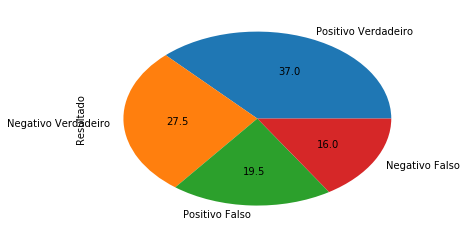

In [159]:
#Plota as porcentagens em gráfico de setor
seg=resposta.Resultado.value_counts(True)*100
seg.plot(kind='pie',autopct="%0.1f",legend=False)

___
## Concluindo

Escreva aqui a sua conclusão.<br /> 
Faça um comparativo qualitativo sobre as medidas obtidas.<br />
Explique como são tratadas as mensagens com dupla negação e sarcasmo.<br />
Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?<br />

Opcionalmente: 
* Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.
* Propor diferentes cenários de uso para o classificador Naive-Bayes. Cenários sem intersecção com este projeto.
* Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer e material de pesquisa sobre o assunto).
